# 캐글에서 데이터 다운로드

In [ ]:
!pip uninstall -y kaggle kagglesdk -q
!pip install --upgrade pip
!pip install kaggle -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
from google.colab import files
import os

# kaggle.json 파일 업로드 (최초 1회만 실행)
if not os.path.exists("/content/kaggle.json"):
    print("kaggle.json 파일을 업로드해주세요:")
    uploaded = files.upload()
    print("업로드 완료!")
else:
    print("kaggle.json 파일이 이미 존재합니다.")

kaggle.json 파일을 업로드해주세요:


Saving kaggle.json to kaggle.json
업로드 완료!


In [ ]:
# Kaggle API 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API 설정 완료!")

Kaggle API 설정 완료!


In [ ]:
# 약 50min
# 교통문제 해결을 위한 CCTV 교통 영상(고속도로)_수도권영동선 데이터셋 다운로드
!kaggle datasets download -d tonyntrish/cctv-seg/1 -p /content/data --force
print("다운로드 완료!")

Dataset URL: https://www.kaggle.com/datasets/tonyntrish/cctv-seg/versions/1
License(s): unknown
100% 62.3G/62.3G [48:34<00:00, 24.7MB/s]
100% 62.3G/62.3G [48:34<00:00, 22.9MB/s]
다운로드 완료!


In [ ]:
# 약 15min
# 압축 해제
!unzip -q data/cctv-seg.zip -d data/train/

# print("압축 해제 및 원본 파일 삭제 완료!")

rm: cannot remove 'cctv-seg.zip': No such file or directory


In [ ]:
# 1. 도구 설치 (이미 설치되어 있을 수 있지만 확인차 실행)
!apt-get install libarchive-tools -y

# 2. 고속 압축 해제
# -x : 압축 풀기
# -f : 파일 지정
# -C : 해제할 폴더 지정
!mkdir -p ./data
!bsdtar -xf /content/data/cctv-seg.zip -C ./cctv_data/train && rm /content/data/cctv-seg.zip

print("고속 압축 해제 및 원본 삭제 완료!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libarchive-tools
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 61.1 kB of archives.
After this operation, 209 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libarchive-tools amd64 3.6.0-1ubuntu1.5 [61.1 kB]
Fetched 61.1 kB in 1s (64.7 kB/s)
Selecting previously unselected package libarchive-tools.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libarchive-tools_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-tools (3.6.0-1ubuntu1.5) ...
Setting up libarchive-tools (3.6.0-1ubuntu1.5) ...
Processing triggers for man-db (2.10.2-1) ...
bsdtar: could not chdir to './cctv_data/train'

고속 압축 해제 및 원본 삭제 완료!


In [ ]:
import torch

print("CUDA 사용 가능:", torch.cuda.is_available())
print("현재 디바이스:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("CUDA 버전:", torch.version.cuda)
print("PyTorch 버전:", torch.__version__)

CUDA 사용 가능: True
현재 디바이스: NVIDIA A100-SXM4-40GB
CUDA 버전: 12.6
PyTorch 버전: 2.9.0+cu126


# 데이터 정리

train 폴더 내에 총 387개의 폴더 존재

label도 마찬가지

3개의 폴더로 분산된 이미지 데이터를 하나의 폴더로 옮기기

In [ ]:
%cd /content/data/train/
%mkdir images
%cd /content/data/train/cam_part1
%mv * /content/data/train/images/
%cd /content/data/train/cam_part2
%mv * /content/data/train/images/
%cd /content/data/train/cam_part3
%mv * /content/data/train/images/
%cd /content/data/train/
%rm -r /content/data/train/cam_part1/
%rm -r /content/data/train/cam_part2/
%rm -r /content/data/train/cam_part3/

/content/data/train
/content/data/train/cam_part1
/content/data/train/cam_part2
/content/data/train/cam_part3
/content/data/train


In [ ]:
%cd /content/data/
%rm cctv-seg.zip

/content/data


xml 형식의 annotation을 txt 형식으로 변환하기 (for yolo)

약 1min

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import shutil
from tqdm import tqdm

# 1. 경로 설정 (스크린샷 기반)
IMAGE_SOURCE_BASE = '/content/data/train/images' # 하위 폴더들이 있는 곳
XML_SOURCE_DIR = '/content/data/train/label'   # XML들이 있는 곳
OUTPUT_BASE = '/content/yolo_data'

# 저장될 폴더 생성
os.makedirs(f'{OUTPUT_BASE}/images/train', exist_ok=True)
os.makedirs(f'{OUTPUT_BASE}/labels/train', exist_ok=True)

# 클래스 매핑 (본인의 데이터에 맞게 수정하세요)
class_mapping = {"car": 0, "bus": 1, "truck": 2}

# 2. 모든 하위 폴더에서 이미지 파일들 미리 검색 (시간 단축용)
print("전체 이미지 경로를 검색 중입니다...")
all_image_paths = glob.glob(os.path.join(IMAGE_SOURCE_BASE, "**/*.png"), recursive=True) + \
                  glob.glob(os.path.join(IMAGE_SOURCE_BASE, "**/*.jpg"), recursive=True)
img_dict = {os.path.basename(f): f for f in all_image_paths}

# 3. 메인 변환 및 이동 로직
xml_files = glob.glob(os.path.join(XML_SOURCE_DIR, "*.xml"))
count = 0

for xml_path in tqdm(xml_files, desc="변환 및 통합 중"):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for image_tag in root.findall('image'):
        img_name = image_tag.get('name') # XML 내부의 이미지 파일명

        # 짝꿍 이미지가 실제 폴더 안에 있는지 확인
        if img_name in img_dict:
            src_img_path = img_dict[img_name]
            w = float(image_tag.get('width'))
            h = float(image_tag.get('height'))

            # YOLO용 TXT 내용 생성
            yolo_lines = []
            for poly in image_tag.findall('polygon'):
                label = poly.get('label')
                if label not in class_mapping: continue

                points = poly.get('points').split(';')
                norm_points = []
                for pt in points:
                    px, py = map(float, pt.split(','))
                    norm_points.append(f"{max(0, min(1, px/w)):.6f} {max(0, min(1, py/h)):.6f}")

                yolo_lines.append(f"{class_mapping[label]} {' '.join(norm_points)}")

            if yolo_lines:
                # 1. 이미지 복사 (Flat하게)
                shutil.copy(src_img_path, f'{OUTPUT_BASE}/images/train/{img_name}')

                # 2. TXT 저장 (Flat하게)
                txt_name = os.path.splitext(img_name)[0] + ".txt"
                with open(f'{OUTPUT_BASE}/labels/train/{txt_name}', 'w') as f:
                    f.write('\n'.join(yolo_lines))
                count += 1

print(f"\n총 {count}세트의 데이터가 {OUTPUT_BASE}에 Flat하게 정리되었습니다!")

전체 이미지 경로를 검색 중입니다...


변환 및 통합 중: 100%|██████████| 387/387 [06:25<00:00,  1.00it/s]


총 37595세트의 데이터가 /content/yolo_data에 Flat하게 정리되었습니다!


전체 데이터 개수 확인

In [ ]:
!ls /content/yolo_data/images/train | wc -l

37595


train 데이터를 train - validation - test 데이터로 나누기

In [ ]:
import os
import random
import shutil
from tqdm import tqdm

# 1. 경로 설정
base_dir = '/content/yolo_data'
splits = ['train', 'val', 'test']
sub_folders = ['images', 'labels']

# 2. 모든 필수 폴더 강제 생성 (에러 방지 핵심)
for s in splits:
    for f in sub_folders:
        os.makedirs(os.path.join(base_dir, f, s), exist_ok=True)

# 3. 초기화: val, test에 있는 파일들을 모두 train으로 안전하게 복구
print("데이터 초기화 중 (모든 파일을 train으로 복구)...")
for split in ['val', 'test']:
    for f_type in sub_folders:
        src_path = os.path.join(base_dir, f_type, split)
        dst_path = os.path.join(base_dir, f_type, 'train')

        files = os.listdir(src_path)
        if files:
            for f in tqdm(files, desc=f"{split} -> train ({f_type})"):
                shutil.move(os.path.join(src_path, f), os.path.join(dst_path, f))

# 4. 전체 이미지 리스트 확보 (확장자 체크)
train_img_dir = os.path.join(base_dir, 'images', 'train')
train_lbl_dir = os.path.join(base_dir, 'labels', 'train')
all_images = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# 5. 비율 계산 (37,595개 기준 8:1:1)
total_count = len(all_images)
num_val = int(total_count * 0.1)
num_test = int(total_count * 0.1)

# 재현성을 위한 시드 고정
random.seed(42)
random.shuffle(all_images)

val_files = all_images[:num_val]
test_files = all_images[num_val:num_val + num_test]

# 6. 파일 이동 함수 정의
def distribute_data(file_list, target_split):
    print(f"\n{target_split} 폴더로 데이터 이동 중...")
    for img_name in tqdm(file_list):
        # 이미지 이동
        src_img = os.path.join(train_img_dir, img_name)
        dst_img = os.path.join(base_dir, 'images', target_split, img_name)

        # 라벨(.txt) 경로 생성 및 이동
        lbl_name = os.path.splitext(img_name)[0] + '.txt'
        src_lbl = os.path.join(train_lbl_dir, lbl_name)
        dst_lbl = os.path.join(base_dir, 'labels', target_split, lbl_name)

        if os.path.exists(src_img):
            shutil.move(src_img, dst_img)
        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)

# 7. 실행
distribute_data(val_files, 'val')
distribute_data(test_files, 'test')

# 최종 확인
print("-" * 30)
print(f"✅ 최종 데이터 구성 완료!")
print(f"Train: {len(os.listdir(train_img_dir))}개")
print(f"Val:   {len(os.listdir(os.path.join(base_dir, 'images', 'val')))}개")
print(f"Test:  {len(os.listdir(os.path.join(base_dir, 'images', 'test')))}개")

데이터 초기화 중 (모든 파일을 train으로 복구)...

val 폴더로 데이터 이동 중...


100%|██████████| 3759/3759 [00:00<00:00, 16244.35it/s]



test 폴더로 데이터 이동 중...


100%|██████████| 3759/3759 [00:00<00:00, 16245.17it/s]

------------------------------
✅ 최종 데이터 구성 완료!
Train: 30077개
Val:   3759개
Test:  3759개


# 샘플 데이터 시각화


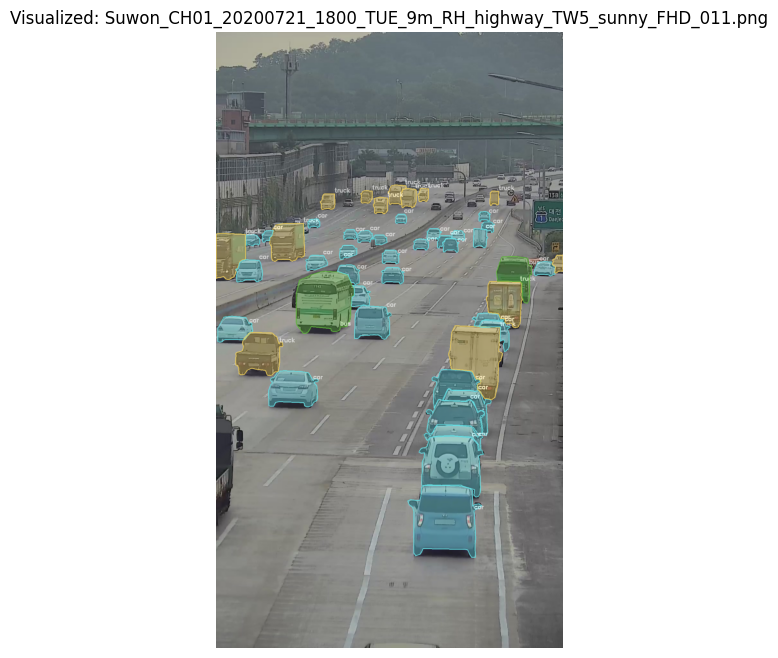

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 설정 (클래스 및 색상)
# ==========================================
# 앞서 설정한 클래스 매핑과 동일하게 맞춤
class_names = {
    0: "car",
    1: "bus",
    2: "truck"
}

# 클래스별 고유 색상 생성 (랜덤)
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)

def visualize_yolo_segmentation(image_path, label_path):
    # 1. 이미지 읽기
    if not os.path.exists(image_path):
        print(f"오류: 이미지 파일을 찾을 수 없습니다. ({image_path})")
        return

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Matplotlib용 변환
    h, w, _ = img.shape

    # 2. 라벨 파일 읽기
    if not os.path.exists(label_path):
        print(f"오류: 라벨 파일을 찾을 수 없습니다. ({label_path})")
        return

    with open(label_path, 'r') as f:
        lines = f.readlines()

    # 시각화용 복사본 (반투명 효과를 위해)
    overlay = img.copy()

    # 3. 각 라인(객체) 처리
    for line in lines:
        parts = line.strip().split()
        if not parts: continue

        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        # 좌표 복원 (0~1 정규화된 값 -> 픽셀 좌표)
        # YOLO Seg 포맷: x1 y1 x2 y2 ... 순서로 되어 있음
        points = []
        for i in range(0, len(coords), 2):
            x = int(coords[i] * w)
            y = int(coords[i+1] * h)
            points.append([x, y])

        # Numpy 배열로 변환 (OpenCV 그리기 함수용)
        pts = np.array(points, np.int32)
        pts = pts.reshape((-1, 1, 2))

        # 색상 지정
        color = [int(c) for c in colors[class_id % len(colors)]]

        # 4. 그리기
        # (1) 폴리곤 내부 채우기 (반투명용 overlay에 그림)
        cv2.fillPoly(overlay, [pts], color)

        # (2) 외곽선 그리기 (진하게)
        cv2.polylines(img, [pts], True, color, 2)

        # (3) 텍스트 라벨 추가 (첫 번째 좌표 근처에)
        label_text = class_names.get(class_id, f"Class {class_id}")
        text_pos = (points[0][0], points[0][1] - 5)
        cv2.putText(img, label_text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # 5. 이미지 합치기 (반투명 효과 적용)
    alpha = 0.4  # 투명도 (0.0 ~ 1.0)
    img_result = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    # 6. 결과 출력
    plt.figure(figsize=(12, 8))
    plt.imshow(img_result)
    plt.axis('off')
    plt.title(f"Visualized: {os.path.basename(image_path)}")
    plt.show()

# ==========================================
# 실행 예시
# ==========================================
# 실제 파일 경로로 수정해서 실행해주세요.
# 예: 같은 폴더에 이미지(png)와 라벨(txt)이 있다고 가정

# 이미지 파일명 (업로드하신 txt파일과 짝이 되는 이미지 경로를 넣어주세요)
img_file = 'Suwon_CH01_20200721_1800_TUE_9m_RH_highway_TW5_sunny_FHD_011.png'
txt_file = 'Suwon_CH01_20200721_1800_TUE_9m_RH_highway_TW5_sunny_FHD_011.txt'

img_path = os.path.join('/content/data/train/images/Suwon_CH01_20200721_1800_TUE_9m_RH_highway_TW5_sunny_FHD/', img_file)
txt_path = os.path.join('/content/data/train/labels/Suwon_CH01_20200721_1800_TUE_9m_RH_highway_TW5_sunny_FHD/', txt_file)

# 이미지 파일이 실제로 존재한다면 아래 주석을 풀고 실행하세요
visualize_yolo_segmentation(img_path, txt_path)

# YOLO 8 돌려보기

In [ ]:
%cd /content/data

/content/data


In [ ]:
import yaml

# YAML에 들어갈 내용 설정
yaml_data = {
    'path': '/content/yolo_data', # 데이터셋 루트 경로
    'train': 'images/train',      # 학습 이미지 경로
    'val': 'images/val',        # 검증 이미지 경로
    'test': 'images/test',       # 테스트 이미지 경로 (선택 사항이나 권장)

    'nc': 3,                      # 클래스 개수
    'names': ['car', 'bus', 'truck'] # 클래스 이름 (인덱스 순서대로)
}

# yaml 파일 저장
yaml_path = '/content/yolo_data/data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"✅ {yaml_path} 생성이 완료되었습니다!")

# 생성된 내용 확인
with open(yaml_path, 'r') as f:
    print("\n--- data.yaml 내용 ---")
    print(f.read())

✅ /content/yolo_data/data.yaml 생성이 완료되었습니다!

--- data.yaml 내용 ---
names:
- car
- bus
- truck
nc: 3
path: /content/yolo_data
test: images/test
train: images/train
val: images/val



In [ ]:
%pip install -q ultralytics

In [ ]:
#아래 학습 시간 약 4시간 20분 소요

In [ ]:
from ultralytics import YOLO

# 1. 모델 불러오기 (v8 또는 11 선택)
# COCO에서 사전학습된 가중치로 시작
model = YOLO('yolov8s-seg.pt')

# 2. 학습 시작

print("batch size = 96")
results = model.train(
    data='/content/yolo_data/data.yaml',  # 위에서 만든 yaml 파일 경로
    epochs=20,                            # 학습 횟수 (테스트는 50, 실제는 100~300 추천)
    imgsz=1024,                            # 이미지 크기 (CCTV가 FHD라면 1024나 1280 추천)
    batch=96,                             # 메모리 오류나면 줄이세요 (8, 4...)
    device=0,                             # GPU 사용 (0번 GPU)
    name='cctv_segmentation',             # 결과 저장 폴더 이름
    val=True,                             # 학습 중 검증 수행 여부 (기본값 True)
    plots=True,                           # 학습 그래프 및 예시 이미지 저장

    # [데이터 증강 파라미터]
    #scale=0.8,       # 이미지 크기 변형 (0.5 -> 0.8로 상향)
    #degrees=10.0,    # 회전 각도 추가
    #translate=0.2,   # 이미지 이동
    #fliplr=0.5,      # 좌우 반전 (CCTV는 방향이 다양하므로 필수)
    #mosaic=1.0,      # 모자이크 증강 (작은 객체 학습에 필수)
    #mixup=0.1,       # 이미지 섞기 (겹친 객체 분리에 도움)
    #hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, # 조명 변화 대응
)

# 3. 결과 확인
print("학습 완료! 결과는 runs/segment/cctv_segmentation 폴더를 확인하세요.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
batch size = 96
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=96, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, img

동영상 돌려보기

In [ ]:
%%bash
cd /content/data/
yolo predict model=/content/data/runs/segment/cctv_segmentation/weights/best.pt source='test_video.mp4' save=True

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8s-seg summary (fused): 86 layers, 11,781,148 parameters, 0 gradients, 39.9 GFLOPs

video 1/1 (frame 1/447) /content/data/test_video.mp4: 576x1024 18 cars, 100.8ms
video 1/1 (frame 2/447) /content/data/test_video.mp4: 576x1024 17 cars, 9.1ms
video 1/1 (frame 3/447) /content/data/test_video.mp4: 576x1024 17 cars, 9.2ms
video 1/1 (frame 4/447) /content/data/test_video.mp4: 576x1024 17 cars, 9.0ms
video 1/1 (frame 5/447) /content/data/test_video.mp4: 576x1024 17 cars, 12.6ms
video 1/1 (frame 6/447) /content/data/test_video.mp4: 576x1024 17 cars, 8.8ms
video 1/1 (frame 7/447) /content/data/test_video.mp4: 576x1024 17 cars, 8.6ms
video 1/1 (frame 8/447) /content/data/test_video.mp4: 576x1024 16 cars, 2 trucks, 8.7ms
video 1/1 (frame 9/447) /content/data/test_video.mp4: 576x1024 16 cars, 2 trucks, 9.4ms
video 1/1 (frame 10/447) /content/data/test_video.mp4: 576x1024 16 cars, 2 trucks, 8.8ms
vid

구글드라이브에 학습 결과 저장


In [ ]:
from google.colab import drive
import os
import subprocess

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# ==========================================
# 설정 (여기를 수정하세요)
# ==========================================
source_folder = '/content/data/runs/segment'               # 복사할 원본 폴더
dest_folder = '/content/drive/MyDrive/cctv_seg_260122'     # 드라이브 저장 경로

# ==========================================
# 실행 로직
# ==========================================
# 저장할 폴더 생성
os.makedirs(dest_folder, exist_ok=True)

print(f"📂 '{source_folder}'의 내용을 '{dest_folder}'로 복사합니다...")

# rsync 명령어 실행 (-a: 아카이브 모드, -v: 상세출력, --progress: 진행률)
# 폴더 통째로 복사
command = f"rsync -av --progress '{source_folder}/' '{dest_folder}'"

# 쉘 명령어 실행
subprocess.call(command, shell=True)

print("\n✅ 복사 작업이 완료되었습니다!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 '/content/data/runs/segment'의 내용을 '/content/drive/MyDrive/cctv_seg_260122'로 복사합니다...

✅ 복사 작업이 완료되었습니다!


# 테스트 셋에서 해보기

In [ ]:
# 1. 기존 v11s_raw_baseline 폴더 삭제
!rm -rf /content/data/cctv-seg/Baseline_Test/v11s_raw_baseline

# 2. v11s_raw_baseline2 폴더의 이름을 v11s_raw_baseline으로 변경
!mv /content/data/cctv-seg/Baseline_Test/v11s_raw_baseline2 /content/data/cctv-seg/Baseline_Test/v11s_raw_baseline

print("✅ 폴더 정리가 완료되었습니다!")

In [ ]:
from ultralytics import YOLO
import pandas as pd

# 1. 모델 로드 및 테스트 수행 (이미 수행했다면 metrics 변수 활용)
model = YOLO('/content/data/runs/segment/cctv_segmentation/weights/best.pt')
metrics = model.val(data='/content/yolo_data/data.yaml', split='test')

# 2. 클래스별 성능 데이터 추출
names = model.names
perf_list = []

for i, name in names.items():
    # .map50(평균) 대신 .ap50(클래스별 리스트)을 사용해야 합니다.
    perf_list.append({
        'Class': name,
        'mIoU (Mask mAP50)': f"{metrics.seg.ap50[i]:.4f}", # 수정됨
        'Precision': f"{metrics.seg.p[i]:.4f}",             # mp 대신 p 사용
        'Recall': f"{metrics.seg.r[i]:.4f}"                # mr 대신 r 사용
    })

# 3. 결과 출력
df_perf = pd.DataFrame(perf_list)
print("\n--- [최종 테스트 셋 클래스별 성능] ---")
print(df_perf)

# 전체 평균 성능(Scalar) 출력
print(f"\n전체 평균 mIoU (Mean Mask mAP50): {metrics.seg.map50:.4f}")

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8s-seg summary (fused): 86 layers, 11,780,761 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 108.6±55.6 MB/s, size: 1839.8 KB)
val: Scanning /content/yolo_data/labels/test... 3759 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3759/3759 105.1it/s 35.8s
val: /content/yolo_data/images/test/Suwon_CH03_20200721_2030_TUE_9m_NH_highway_OW5_sunny_FHD_089.png: 14 duplicate labels removed
val: /content/yolo_data/images/test/Suwon_CH06_20201010_2003_SAT_9m_NH_highway_OW5_sunny_FHD_088.png: 1 duplicate labels removed
val: /content/yolo_data/images/test/Suwon_CH09_20200721_1800_TUE_9m_NH_highway_OW5_sunny_FHD_013.png: 2 duplicate labels removed
val: New cache created: /content/yolo_data/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23

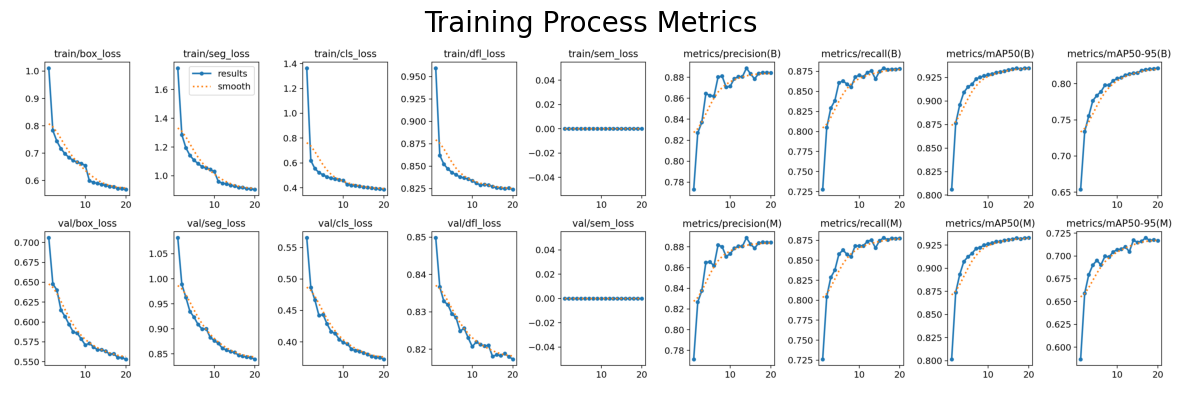

In [ ]:
#학습 과정 지표 시각화
import matplotlib.pyplot as plt
import cv2

# 학습 결과 이미지 경로
results_path = '/content/data/runs/segment/cctv_segmentation2/results.png'

# 이미지 출력
img = cv2.imread(results_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Training Process Metrics", fontsize=20)
plt.show()

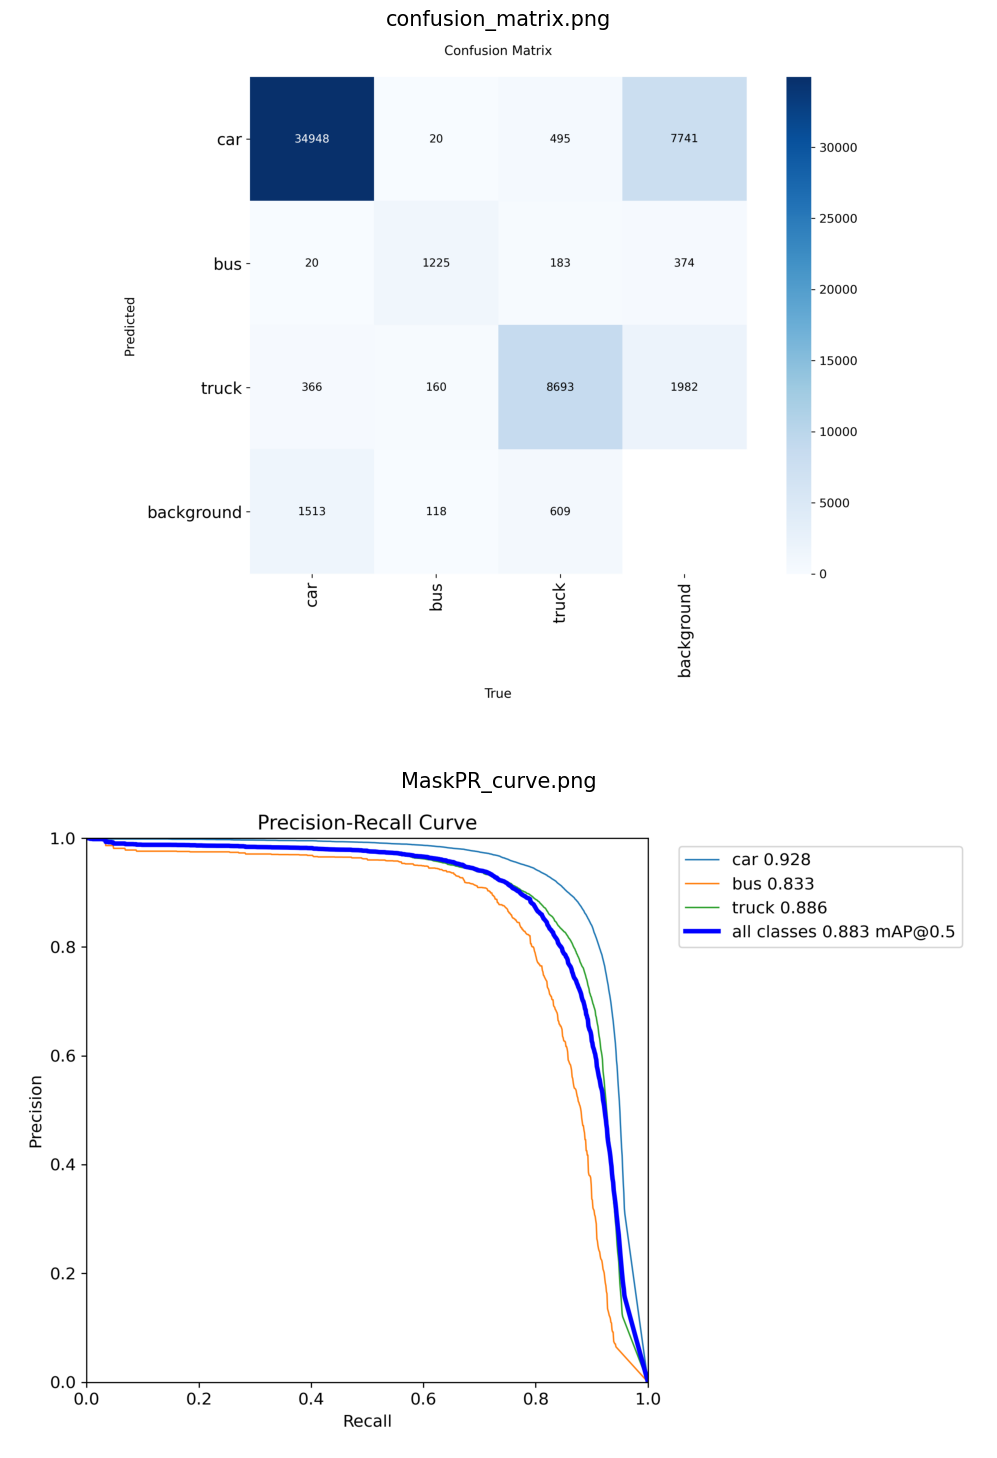

In [ ]:
#테스트 셋 평가 결과 시각화
import matplotlib.pyplot as plt
import cv2
import os

# 테스트 평가 결과가 저장된 경로
val_result_dir = '/content/data/runs/segment/val/'

# 주요 결과 파일 리스트
target_files = ['confusion_matrix.png', 'F1_curve.png', 'MaskPR_curve.png']

plt.figure(figsize=(20, 15))
for i, file_name in enumerate(target_files):
    file_path = os.path.join(val_result_dir, file_name)
    if os.path.exists(file_path):
        img = cv2.imread(file_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 2, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(file_name, fontsize=15)

plt.tight_layout()
plt.show()


image 1/1 /content/yolo_data/images/test/Suwon_CH10_20200721_2100_TUE_9m_NH_highway_TW5_sunny_FHD_043.png: 1024x576 4 cars, 112.5ms
Speed: 4.8ms preprocess, 112.5ms inference, 23.4ms postprocess per image at shape (1, 3, 1024, 576)


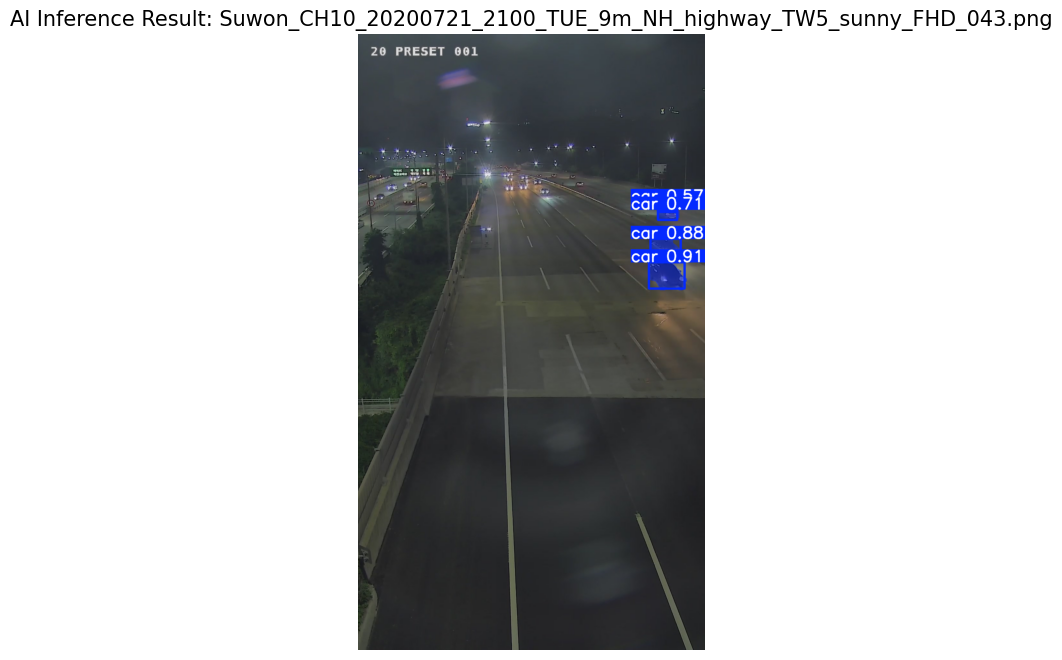


image 1/1 /content/yolo_data/images/test/Suwon_CH10_20200721_1600_TUE_9m_NH_highway_TW5_sunny_FHD_056.png: 1024x576 5 cars, 6 trucks, 11.6ms
Speed: 4.7ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 576)


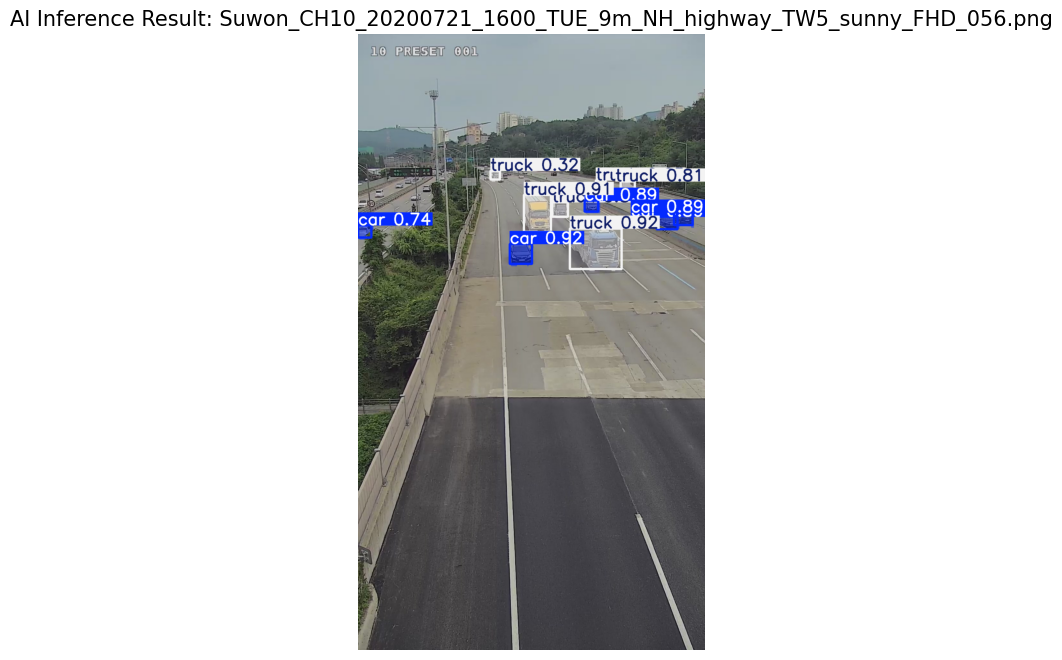


image 1/1 /content/yolo_data/images/test/Suwon_CH03_20201011_2114_SUN_9m_NH_highway_OW5_sunny_FHD_001.png: 1024x576 10 cars, 11.4ms
Speed: 4.6ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 576)


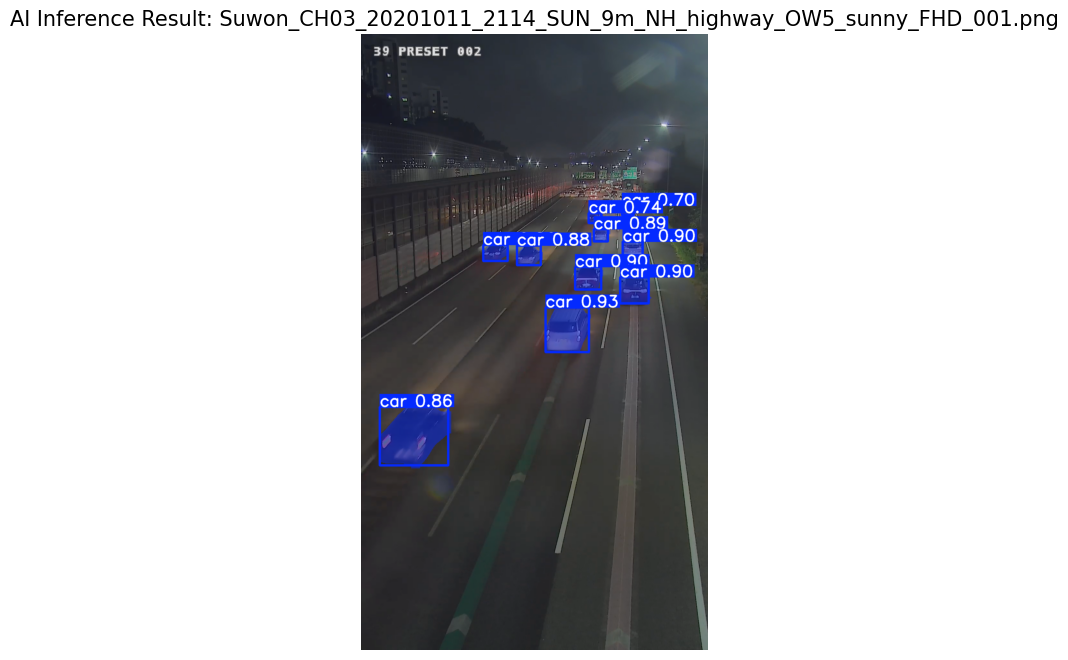

In [ ]:
#실제 이미지 추론 시각화
import matplotlib.pyplot as plt
import cv2
import glob
from ultralytics import YOLO

# 1. 모델 로드
model = YOLO('/content/data/runs/segment/cctv_segmentation/weights/best.pt')

# 2. 테스트 이미지 샘플 추출 (3장)
test_samples = glob.glob('/content/yolo_data/images/test/*.png')[:3]

for img_path in test_samples:
    # 추론 수행 (Confidence threshold 0.3 적용)
    results = model.predict(source=img_path, conf=0.3)

    # 마스크 및 결과 플로팅
    res_plotted = results[0].plot()
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(res_rgb)
    plt.title(f"AI Inference Result: {img_path.split('/')[-1]}", fontsize=15)
    plt.axis('off')
    plt.show()

# 유튜브 테스트


In [ ]:
!pip install yt-dlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.1 MB/s  0:00:00


In [ ]:
# 1. yt-dlp 설치 및 업데이트
!pip install -U yt-dlp

# 2. 원하는 구간(00:00 ~ 00:30)만 잘라서 다운로드
# --download-sections 옵션을 사용하면 서버에서 잘라서 가져오므로 매우 빠릅니다.
video_url = 'https://www.youtube.com/watch?v=wqctLW0Hb_0'
!yt-dlp -f "bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best" \
    --download-sections "*00:00-00:30" \
    --force-keyframes-at-cuts \
    {video_url} -o "highway_short.mp4"

print("✅ 30초 구간 다운로드 완료!")

[youtube] Extracting URL: https://www.youtube.com/watch?v=wqctLW0Hb_0
[youtube] wqctLW0Hb_0: Downloading webpage
[youtube] wqctLW0Hb_0: Downloading android sdkless player API JSON
[youtube] wqctLW0Hb_0: Downloading web safari player API JSON
[youtube] wqctLW0Hb_0: Downloading m3u8 information
[info] wqctLW0Hb_0: Downloading 1 format(s): 136+140
[info] wqctLW0Hb_0: Downloading 1 time ranges: 0.0-30.0
[download] Destination: highway_short.mp4
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'https://rr5---sn-npoe7ndd.googlevideo.com/videoplayback?expire=1769081848&ei=mLdxaerFMYW19fwPhb_goA0&ip=136.110.19.74&id=o-ANbb0F17HOUXxbDG5YxZatXHPV_dIClnTJKKXWHivzNL&itag=136&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&cps=1&met=1769060248%2C&mh=qV&mm=31%2C26&mn=sn-npoe7ndd%2Csn-30a7rne6&ms=au%2Conr&mv=m&mvi=5&pl=18&rms=au%2Cau&initcwndbps=1986250&bui=AW-iu_ofe4cI8LaUAOeqWkTYTfuLH-l4RGZtO_z4BpTCdiEs7QTdjLMkwPhABPjctC1IRjAHH-b7Tjrl&spc=q5xjPD2QZIoe&vprv=1&svpuc=1&mime=video%2Fmp4&rqh=1&gir=yes&clen=21

In [ ]:
from ultralytics import YOLO

# 1. 모델 로드 (v11s_raw_baseline 경로 반영)
model_path = '/content/data/runs/segment/cctv_segmentation/weights/best.pt'
model = YOLO(model_path)

# 2. 30초짜리 짧은 영상으로 추론
results = model.predict(
    source='highway_short.mp4',
    conf=0.3,           # 수치 참고하여 설정
    save=True,
    project='Video_Test',
    name='short_inference'
)

print("✅ 분석 완료! Video_Test/short_inference 폴더를 확인하세요.")


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/750) /content/data/highway_short.mp4: 384x640 9 cars, 2 trucks, 96.8ms
video 1/1 (frame 2/750) /content/data/highway_short.mp4: 384x640 9 cars, 2 trucks, 9.1ms
video 1/1 (frame 3/750) /content/data/highway_short.mp4: 384x640 9 cars, 2 trucks, 8.9ms
video 1/1 (frame 4/750) /content/data/highway_short.mp4: 384x640 9 cars, 2 trucks, 8.9ms
video 1/1 (frame 5/750) /content/data/highway_short.mp4: 384x640 9 cars, 2 trucks, 8.9ms
video 1/1 (f

# 실시간


실시간 cctv 영상 url 가져오기 (코랩에서 실행 불가)

로컬에서 .py 형식으로 저장해서 실행해야함

```
import requests
import json
import urllib3

# SSL 경고 메시지 끄기
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def get_cctv_list():
    # ------------------------------------------------------------------
    # [입력] API KEY
    # ------------------------------------------------------------------
    API_KEY = "c78d3ec633114e4085cc92e5fe27aaa8"
    
    # ------------------------------------------------------------------
    # [설정] 찾고 싶은 CCTV 목록 (정확한 이름 매칭을 위해 리스트로 관리)
    # ------------------------------------------------------------------
    TARGET_LIST = [
        "[경부선] 서초",
        "[경부선] 금곡교",
        "[경부선] 달래내2",
        "[경부선] 수원",
        "[경부선] 신갈분기점2",
        "[경부선] 판교3"
    ]

    # API 요청 설정
    url = "https://openapi.its.go.kr:9443/cctvInfo"
    
    params = {
        "apiKey": API_KEY,
        "type": "ex",        # 고속도로
        "cctvType": "1",     # 동영상
        "minX": "126.0",     # 전국 범위
        "maxX": "130.0",
        "minY": "34.0",
        "maxY": "38.0",
        "getType": "json"
    }

    print(f"🚀 [ITS API] 데이터 요청 중...")

    try:
        response = requests.get(url, params=params, timeout=10, verify=False)
        response.raise_for_status()
        data = response.json()
        
        # 데이터 구조 파싱
        cctv_data_list = []
        if "response" in data and "data" in data["response"]:
            cctv_data_list = data["response"]["data"]
        elif "data" in data:
            cctv_data_list = data["data"]
        else:
            cctv_data_list = data

        print(f"✅ 전체 CCTV 데이터 수신 완료 (총 {len(cctv_data_list)}개)")
        
        # 결과를 담을 리스트 초기화
        final_results = []

        # 전체 CCTV 데이터를 순회하며 타겟 찾기
        for item in cctv_data_list:
            cctv_name = item.get("cctvname") or item.get("cctvName") or ""
            cctv_url = item.get("cctvurl") or item.get("cctvUrl")
            
            # 이름과 URL이 유효한 경우에만 검사
            if cctv_name and cctv_url:
                # 우리가 찾는 목록에 포함되어 있는지 확인 (부분 일치 허용)
                # 예: API가 "[경부선] 서초(서울)"이라고 줘도 "[경부선] 서초"가 포함되어 있으면 찾음
                for target in TARGET_LIST:
                    if target in cctv_name:
                        #if "신갈분기점2" in cctv_name:
                        #    continue  # '신갈분기점2'는 저장하지 않고 건너뜀
                        if "기흥휴게소" in cctv_name:
                            continue
                        if "기흥동탄" in cctv_name:
                            continue

                        cctv_info = {
                            "name": cctv_name,
                            "url": cctv_url,
                            "coord": (item.get('coordx'), item.get('coordy'))
                        }
                        final_results.append(cctv_info)
                        # 중복 추가 방지 (한 CCTV가 여러 타겟에 걸릴 일은 드물지만 안전장치)
                        break

        # 결과 출력 및 반환
        print("\n" + "="*60)
        print(f"🎉 총 {len(final_results)}개의 타겟 CCTV를 찾았습니다.")
        print("="*60)
        
        for res in final_results:
            print(f"📍 {res['name']}")
            print(f"   🔗 {res['url']}")
            print("-" * 60)

        # 못 찾은 CCTV가 있는지 확인
        found_names = [res['name'] for res in final_results]
        for target in TARGET_LIST:
            # 타겟 이름이 포함된 결과가 하나도 없으면 경고
            if not any(target in found for found in found_names):
                print(f"⚠️ [주의] '{target}' 은(는) 목록에서 찾지 못했습니다.")

        return final_results

    except Exception as e:
        print(f"\n❌ 오류 발생: {e}")
        return []

if __name__ == "__main__":
    # 함수 실행 및 결과 리스트 받기
    cctv_urls = get_cctv_list()

    print(type(cctv_urls))
    print(len(cctv_urls))
    print(cctv_urls)


```



In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.3 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
from ultralytics import YOLO
import ipywidgets as widgets  # 위젯 라이브러리 추가
from IPython.display import display
import time

# =========================================================
# [설정]
# 1. 모델 경로
#MODEL_PATH = "/content/data/runs/segment/cctv_segmentation/weights/best.pt"
MODEL_PATH = "/content/data/runs/segment/cctv_segmentation/weights/best.pt"

# 2. 스트리밍 주소 -> 2시간마다 바뀌니 실행할 때마다 업데이트해야함
STREAM_URL = "http://cctvsec.ktict.co.kr/75/hHz/2fVJU2clao7socYj5a0jZJPK2lgXxMyTz5qNxrxLIaB4X6xYyEW22Qn8xqDORZkRPSbra5pG4Ls9uAuG7qSB2gtu2OKagPub1pyR9Pc="
# =========================================================

def run_smooth_segmentation():
    # 1. 모델 로드
    print(f"🔄 모델 로딩 중: {MODEL_PATH}...")
    try:
        model = YOLO(MODEL_PATH)
    except Exception as e:
        print(f"❌ 모델 로드 실패: {e}")
        return

    # 2. 비디오 스트림 연결
    cap = cv2.VideoCapture(STREAM_URL)
    if not cap.isOpened():
        print("❌ 스트림 연결 실패")
        return

    print("✅ 연결 성공! 부드러운 화면 출력을 시작합니다.")

    # -----------------------------------------------------
    # ★ 핵심 변경점: 이미지 위젯 생성
    # -----------------------------------------------------
    # 빈 이미지 위젯을 미리 만들어두고, 한 번만 display 합니다.
    # width/height는 보시기 편한 크기로 조절하세요.
    image_widget = widgets.Image(format='jpeg', width=640, height=480)

    # 위젯을 화면에 뿌립니다 (이후에는 image_widget.value만 바꿉니다)
    display(image_widget)

    # 정보 표시용 레이블 (FPS 등 표시)
    info_widget = widgets.Label(value="초기화 중...")
    display(info_widget)

    frame_count = 0
    t1 = time.time()

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                info_widget.value = "스트림이 종료되었거나 네트워크가 불안정합니다."
                break

            # -----------------------------------------------------
            # [최적화] 모든 프레임을 추론하면 느릴 수 있음
            # 2프레임마다 1번만 추론 (필요하면 3이나 1로 변경)
            # -----------------------------------------------------
            process_every_n_frames = 1

            if frame_count % process_every_n_frames == 0:
                # 추론 (Segmentation)
                results = model.predict(frame, conf=0.5, imgsz=640, verbose=False)
                # 결과 그리기
                annotated_frame = results[0].plot(boxes=False)
            else:
                # 추론 안 하는 프레임은 원본 그대로 보여줌 (속도 향상)
                annotated_frame = frame

            # -----------------------------------------------------
            # [출력] 위젯 값 업데이트 (깜빡임 없음)
            # -----------------------------------------------------
            # 이미지를 JPEG 바이트로 인코딩
            _, encoded_img = cv2.imencode('.jpeg', annotated_frame)

            # 위젯의 value에 바이트 데이터를 꽂아넣습니다.
            image_widget.value = encoded_img.tobytes()

            # FPS 계산 및 정보 업데이트
            frame_count += 1
            if frame_count % 10 == 0:
                t2 = time.time()
                fps = 10 / (t2 - t1)
                info_widget.value = f"FPS: {fps:.2f} | Frame: {frame_count}"
                t1 = time.time()

    except KeyboardInterrupt:
        print("\n🛑 중지되었습니다.")
    finally:
        cap.release()

# 실행
if __name__ == "__main__":
    import os
    if not os.path.exists(MODEL_PATH):
        print(f"⚠️ 모델 파일({MODEL_PATH})이 없어 기본 모델을 다운로드합니다.")
        MODEL_PATH = "yolov8s-seg.pt"

    run_smooth_segmentation()

🔄 모델 로딩 중: /content/data/runs/segment/cctv_segmentation/weights/best.pt...
✅ 연결 성공! 부드러운 화면 출력을 시작합니다.


Image(value=b'', format='jpeg', height='480', width='640')

Label(value='초기화 중...')


🛑 중지되었습니다.


마스크 적용

In [ ]:
import cv2
import torch
import numpy as np  # numpy 추가
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display
import time
import os

# =========================================================
# [설정]
# 1. 모델 경로
MODEL_PATH = "/content/best_v8s.pt"

# 2. 스트리밍 주소 (실행 시마다 확인 필요)
STREAM_URL = "http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxYUz5DB0cXLS0Pb2iS5J4T0tITK/D54U+SNoVmLYFAJKY="

# 3. 마스크 이미지 경로 (업로드한 png 파일 경로로 수정하세요)
# 흰색(1) 부분이 탐지할 영역, 검은색(0) 부분이 무시할 영역이어야 합니다.
MASK_PATH = "/content/mask.png"
# =========================================================

def run_masked_segmentation():
    # 1. 모델 로드
    print(f"🔄 모델 로딩 중: {MODEL_PATH}...")
    try:
        model = YOLO(MODEL_PATH)
    except Exception as e:
        print(f"❌ 모델 로드 실패: {e}")
        # 테스트용으로 기본 모델 다운로드 시도
        print("⚠️ 기본 모델(yolov8s-seg.pt)로 전환합니다.")
        model = YOLO("yolov8s-seg.pt")

    # 2. 마스크 이미지 로드
    if os.path.exists(MASK_PATH):
        # 흑백 모드(Grayscale)로 로드
        mask_origin = cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE)
        print(f"✅ 마스크 파일 로드 성공: {MASK_PATH}")
    else:
        print(f"⚠️ 마스크 파일이 없습니다: {MASK_PATH}")
        print("   -> 마스크 없이 전체 화면을 탐지합니다.")
        mask_origin = None

    # 3. 비디오 스트림 연결
    cap = cv2.VideoCapture(STREAM_URL)
    if not cap.isOpened():
        print("❌ 스트림 연결 실패")
        return

    print("✅ 연결 성공! 마스킹된 영역 탐지를 시작합니다.")

    # 4. 위젯 설정
    image_widget = widgets.Image(format='jpeg', width=640, height=480)
    display(image_widget)
    info_widget = widgets.Label(value="초기화 중...")
    display(info_widget)

    frame_count = 0
    t1 = time.time()

    # 마스크 리사이징 여부를 확인하기 위한 플래그
    mask_processed = None

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                info_widget.value = "스트림이 종료되었거나 네트워크가 불안정합니다."
                break

            # -----------------------------------------------------
            # [마스크 처리] 최초 1회 또는 크기가 안 맞을 때 리사이징
            # -----------------------------------------------------
            if mask_origin is not None:
                if mask_processed is None or mask_processed.shape != frame.shape[:2]:
                    # 프레임 크기에 맞춰 마스크 크기 조절 (width, height)
                    h, w = frame.shape[:2]
                    mask_resized = cv2.resize(mask_origin, (w, h))

                    # 이진화 (혹시 모를 그라데이션 제거, 127 이상은 255로)
                    _, mask_processed = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)
                    print(f"ℹ️ 마스크 크기 조정 완료: {w}x{h}")

            # -----------------------------------------------------
            # [최적화] N 프레임마다 추론
            # -----------------------------------------------------
            process_every_n_frames = 1  # 2프레임마다 추론

            if frame_count % process_every_n_frames == 0:
                # A. 마스킹 적용 (ROI 추출)
                if mask_processed is not None:
                    # 마스크가 있는 영역만 남기고 나머지는 검은색(0) 처리
                    masked_frame = cv2.bitwise_and(frame, frame, mask=mask_processed)
                else:
                    masked_frame = frame

                # B. 추론 수행 (검은색 배경이 된 이미지를 모델에 넣음)
                results = model.predict(masked_frame, conf=0.5, imgsz=640, verbose=False)

                # C. 결과 시각화
                # plot()은 추론된 이미지(배경은 masked_frame과 동일하게 검음)를 반환
                plot_img = results[0].plot(boxes=False)

                # D. [중요] 자연스러운 출력을 위한 합성
                # plot_img는 마스크 밖이 검은색이므로,
                # 원본 frame의 배경을 다시 살려서 보여주는 것이 보기에 좋습니다.
                if mask_processed is not None:
                    final_output = frame.copy()
                    # 마스크가 흰색(255)인 부분만 추론 결과로 덮어씌움
                    # mask_processed == 255 인 인덱스를 활용
                    final_output[mask_processed == 255] = plot_img[mask_processed == 255]
                else:
                    final_output = plot_img
            else:
                # 추론 안 하는 프레임은 그냥 원본 출력 (또는 이전 결과 유지 가능)
                final_output = frame

            # -----------------------------------------------------
            # [출력]
            # -----------------------------------------------------
            _, encoded_img = cv2.imencode('.jpeg', final_output)
            image_widget.value = encoded_img.tobytes()

            frame_count += 1
            if frame_count % 10 == 0:
                t2 = time.time()
                fps = 10 / (t2 - t1)
                info_widget.value = f"FPS: {fps:.2f} | Frame: {frame_count}"
                t1 = time.time()

    except KeyboardInterrupt:
        print("\n🛑 중지되었습니다.")
    finally:
        cap.release()

if __name__ == "__main__":
    run_masked_segmentation()

🔄 모델 로딩 중: /content/best_v8s.pt...
✅ 마스크 파일 로드 성공: /content/mask.png
✅ 연결 성공! 마스킹된 영역 탐지를 시작합니다.


Image(value=b'', format='jpeg', height='480', width='640')

Label(value='초기화 중...')

ℹ️ 마스크 크기 조정 완료: 720x480

🛑 중지되었습니다.


마스크 적용 v2


In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display
import time
import os

# =========================================================
# [설정]
MODEL_PATH = "/content/best_v8s.pt"
STREAM_URL = "http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxYUz5DB0cXLS0Pb2iS5J4T0tITK/D54U+SNoVmLYFAJKY="
MASK_PATH = "/content/mask.png"
# =========================================================

def is_box_in_mask(box, mask_img, threshold=0.5):
    """
    박스의 중심점이 마스크의 흰색(유효) 영역에 있는지 확인합니다.
    """
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)

    # 좌표가 이미지 범위를 벗어나지 않도록 클리핑
    h, w = mask_img.shape
    center_x = max(0, min(center_x, w - 1))
    center_y = max(0, min(center_y, h - 1))

    # 마스크의 해당 좌표 값이 0(검은색)이 아니면 유효한 영역
    return mask_img[center_y, center_x] > 0

def run_smart_filtering_segmentation():
    # 1. 모델 로드
    print(f"🔄 모델 로딩 중: {MODEL_PATH}...")
    try:
        model = YOLO(MODEL_PATH)
    except:
        print("⚠️ 모델 로드 실패, 기본 모델 사용")
        model = YOLO("yolov8s-seg.pt")

    # 2. 마스크 로드 (존재 여부 확인)
    mask_filter = None
    if os.path.exists(MASK_PATH):
        mask_filter = cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE)
        # 이진화 처리 (확실하게 0과 255로 구분)
        _, mask_filter = cv2.threshold(mask_filter, 127, 255, cv2.THRESH_BINARY)
        print("✅ 마스크 필터 적용: 탐지 후 영역 밖 객체는 제외합니다.")

    cap = cv2.VideoCapture(STREAM_URL)

    image_widget = widgets.Image(format='jpeg', width=640, height=480)
    display(image_widget)
    info_widget = widgets.Label(value="초기화 중...")
    display(info_widget)

    frame_count = 0
    t1 = time.time()

    # 마스크 리사이즈용 캐시
    resized_mask = None

    try:
        while True:
            ret, frame = cap.read()
            if not ret: break

            # [마스크 크기 맞추기] - 프레임 크기가 변할 수 있으므로
            if mask_filter is not None:
                if resized_mask is None or resized_mask.shape != frame.shape[:2]:
                    resized_mask = cv2.resize(mask_filter, (frame.shape[1], frame.shape[0]))

            if frame_count % 2 == 0:
                # -----------------------------------------------------
                # ★ 성능 향상 포인트 1: retina_masks=True
                # 마스크 품질을 고해상도로 처리하여 깍두기 현상을 줄임
                # -----------------------------------------------------
                # ★ 성능 향상 포인트 2: 원본 프레임(frame) 전체를 추론
                # 마스킹된 이미지가 아니라 원본을 넣어야 모델이 문맥을 이해함
                # -----------------------------------------------------
                results = model.predict(
                    frame,
                    conf=0.4,       # 감도 조절 (너무 낮으면 노이즈, 높으면 못 찾음)
                    imgsz=640,      # 필요 시 1280으로 올리면 작게 찍힌 것도 잘 찾음 (속도는 느려짐)
                    retina_masks=True,
                    verbose=False
                )

                result = results[0]

                # 결과 그리기용 복사본
                annotated_frame = frame.copy()

                # 탐지된 객체가 있을 경우
                if result.masks is not None:
                    # 마스크와 박스를 하나씩 순회하며 필터링
                    # (YOLOv8의 plot()은 전체를 다 그리므로, 직접 그려야 필터링 가능)

                    # 1. 마스크가 없는 경우(일반 탐지)는 그냥 plot 호출이 빠름
                    if resized_mask is None:
                        annotated_frame = result.plot(boxes=False)
                    else:
                        # 2. 마스크 필터링이 필요한 경우 직접 그리기
                        # 마스크 영역(ROI) 안에 중심이 있는 객체만 선택
                        indices_to_keep = []
                        for i, box in enumerate(result.boxes):
                            if is_box_in_mask(box, resized_mask):
                                indices_to_keep.append(i)

                        # 유효한 객체가 하나라도 있으면 그리기
                        if indices_to_keep:
                            # 선택된 인덱스만 남겨서 plot (YOLO 유틸리티 활용)
                            # result[indices_to_keep] 문법으로 필터링된 결과셋 생성 가능
                            filtered_result = result[indices_to_keep]
                            annotated_frame = filtered_result.plot(boxes=False, img=frame.copy())
                        else:
                            # 영역 내 객체가 없으면 원본 그대로
                            annotated_frame = frame
                else:
                    annotated_frame = frame

            else:
                annotated_frame = frame # 이전 프레임 유지 혹은 원본

            # 출력
            _, encoded_img = cv2.imencode('.jpeg', annotated_frame)
            image_widget.value = encoded_img.tobytes()

            frame_count += 1
            if frame_count % 10 == 0:
                fps = 10 / (time.time() - t1)
                info_widget.value = f"FPS: {fps:.2f} (Retina: On, Filter: Output)"
                t1 = time.time()

    except KeyboardInterrupt:
        print("중지됨")
    finally:
        cap.release()

if __name__ == "__main__":
    run_smart_filtering_segmentation()

🔄 모델 로딩 중: /content/best_v8s.pt...
✅ 마스크 필터 적용: 탐지 후 영역 밖 객체는 제외합니다.


Image(value=b'', format='jpeg', height='480', width='640')

Label(value='초기화 중...')

중지됨


In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display
import time
import threading
import os

# =========================================================
# [설정]
MODEL_PATH = "/content/best_v8s.pt"
STREAM_URL = "http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxYUz5DB0cXLS0Pb2iS5J4T0tITK/D54U+SNoVmLYFAJKY="
MASK_PATH = "/content/mask.png"

# 추론 간격 (숫자가 클수록 FPS는 오르지만, 빠른 물체 반응은 느려짐)
# 3 정도가 코랩에서 적당합니다.
INFERENCE_INTERVAL = 3
# =========================================================

# 1. 스트림 끊김 방지 및 최신 프레임 유지 (버퍼링 제거)
class RealTimeStream:
    def __init__(self, src):
        self.cap = cv2.VideoCapture(src)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1) # 버퍼 최소화
        self.ret, self.frame = self.cap.read()
        self.running = True
        self.lock = threading.Lock()
        self.thread = threading.Thread(target=self.update, args=(), daemon=True)
        self.thread.start()

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if not ret:
                self.running = False
                break
            with self.lock:
                self.ret = ret
                self.frame = frame
            time.sleep(0.005) # CPU 과부하 방지

    def read(self):
        with self.lock:
            return self.ret, self.frame.copy() if self.frame is not None else None

    def release(self):
        self.running = False
        self.thread.join()
        self.cap.release()

def enhance_frame(frame):
    # 1. 노이즈 제거 (약하게)
    # GaussianBlur로 자글자글한 압축 노이즈를 살짝 뭉갭니다.
    denoised = cv2.GaussianBlur(frame, (3, 3), 0)

    # 2. 샤픈 (Sharpening) - 윤곽선 강조
    # 중앙 픽셀을 강조하고 주변을 깎아서 경계를 날카롭게 만듭니다.
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    return sharpened

# 2. 마스크 필터링 함수 (좌표 기반)
def is_box_in_mask(box, mask_img):
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    h, w = mask_img.shape
    center_x = max(0, min(center_x, w - 1))
    center_y = max(0, min(center_y, h - 1))
    return mask_img[center_y, center_x] > 0

def run_colab_optimized_segmentation():
    # GPU 강제 사용 및 FP16 설정
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"🚀 장치 설정: {device}")

    print(f"🔄 모델 로딩 중: {MODEL_PATH}...")
    try:
        model = YOLO(MODEL_PATH)
    except:
        print("⚠️ 모델 로드 실패, 기본 모델 사용")
        model = YOLO("yolov8s-seg.pt")

    # 모델 웜업 (초기 렉 방지)
    # 더미 데이터로 한번 돌려서 GPU 메모리에 올림
    dummy_input = np.zeros((640, 640, 3), dtype=np.uint8)
    model.predict(dummy_input, device=device, half=True, verbose=False)
    print("🔥 모델 웜업 완료!")

    # 마스크 로드
    mask_filter = None
    if os.path.exists(MASK_PATH):
        mask_filter = cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE)
        _, mask_filter = cv2.threshold(mask_filter, 127, 255, cv2.THRESH_BINARY)
        print("✅ ROI 마스크 로드 완료")

    stream = RealTimeStream(STREAM_URL)
    time.sleep(1.0) # 스트림 안정화 대기

    if not stream.ret:
        print("❌ 스트림 연결 실패")
        return

    # 위젯 설정
    image_widget = widgets.Image(format='jpeg', width=640, height=480)
    display(image_widget)
    fps_widget = widgets.Label(value="FPS 계산 중...")
    display(fps_widget)

    frame_count = 0
    t1 = time.time()

    resized_mask = None

    # [핵심] '깜빡임 방지'를 위한 변수
    # 추론하지 않는 프레임에서도 이 결과를 재사용합니다.
    last_results = None

    try:
        while True:
            ret, frame = stream.read()
            if not ret or frame is None:
                continue

            frame = enhance_frame(frame)

            # 마스크 리사이징 (최초 1회 또는 해상도 변경 시)
            if mask_filter is not None:
                if resized_mask is None or resized_mask.shape != frame.shape[:2]:
                    resized_mask = cv2.resize(mask_filter, (frame.shape[1], frame.shape[0]))

            # =========================================================
            # [추론 로직] N프레임마다 실행 (GPU 부하 감소)
            # =========================================================
            if frame_count % INFERENCE_INTERVAL == 0:
                # model.track 사용 -> 객체 ID 부여로 떨림 보정 효과
                # persist=True -> 객체가 잠깐 가려져도 ID 유지
                results = model.track(
                    frame,
                    persist=True,
                    conf=0.4,
                    imgsz=640,
                    device=device,
                    half=True, # FP16 사용 (속도 향상)
                    verbose=False,
                    tracker="bytetrack.yaml" # 추적 알고리즘
                )

                # 결과를 변수에 저장 (다음 프레임 재사용)
                # ROI 필터링을 여기서 미리 해서 저장해도 되지만,
                # plot() 객체 자체를 저장하는 건 불가능하므로 result 객체를 저장
                last_results = results[0]

            # =========================================================
            # [그리기 로직] 매 프레임 실행 (깜빡임 해결)
            # =========================================================
            annotated_frame = frame.copy() # 원본 복사

            # 저장된 결과가 있다면 그리기 수행
            if last_results is not None and last_results.masks is not None:
                # 1. 마스크 필터링 (ROI 영역 밖 제외)
                indices_to_keep = []

                # boxes가 없으면 masks도 의미 없으므로 체크
                if last_results.boxes is not None:
                    for i, box in enumerate(last_results.boxes):
                        # 마스크가 없으면 통과, 있으면 검사
                        if resized_mask is None or is_box_in_mask(box, resized_mask):
                            indices_to_keep.append(i)

                # 2. 유효한 객체만 그리기
                if indices_to_keep:
                    # 선택된 인덱스의 객체들만으로 새로운 결과 객체 생성 느낌으로 plot
                    # (YOLOv8의 인덱싱 기능을 활용)
                    filtered_result = last_results[indices_to_keep]

                    # img=annotated_frame 옵션: 현재 프레임 위에 덮어쓰기
                    # 이렇게 하면 '옛날 마스크'를 '현재 프레임' 위에 입히므로
                    # 객체가 움직이면 약간 어긋날 순 있지만, 깜빡임은 완벽히 사라짐
                    annotated_frame = filtered_result.plot(boxes=False, img=annotated_frame)

            # =========================================================
            # [출력 최적화]
            # =========================================================
            # JPEG 인코딩 품질을 80~90으로 낮추면 전송 속도 빨라짐 (기본 95)
            _, encoded_img = cv2.imencode('.jpeg', annotated_frame, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
            image_widget.value = encoded_img.tobytes()

            frame_count += 1
            if frame_count % 10 == 0:
                curr_time = time.time()
                fps = 10 / (curr_time - t1)
                fps_widget.value = f"FPS: {fps:.1f} | Mode: Tracking + Persistence"
                t1 = curr_time

    except KeyboardInterrupt:
        print("중지됨")
    finally:
        stream.release()
        torch.cuda.empty_cache() # GPU 메모리 정리

if __name__ == "__main__":
    run_colab_optimized_segmentation()

🚀 장치 설정: cuda
🔄 모델 로딩 중: /content/best_v8s.pt...
🔥 모델 웜업 완료!
✅ ROI 마스크 로드 완료


Image(value=b'', format='jpeg', height='480', width='640')

Label(value='FPS 계산 중...')

중지됨


DEVICE: cuda:0 | half: True
✅ YOLO loaded: /content/best_v8s.pt
📌 model.names: {0: 'car', 1: 'bus', 2: 'truck'}
🎥 Stream: size=(720,480), fps~30.00
🧪 ffmpeg cmd: ffmpeg -hide_banner -loglevel error -i http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxYtW+bE6fzXLD6by/nC2T11tITK/D54U+SNoVmLYFAJKY= -an -vf scale=720:480 -pix_fmt bgr24 -f rawvideo pipe:1
✅ Start real-time inference. (Stop: interrupt/ESC)


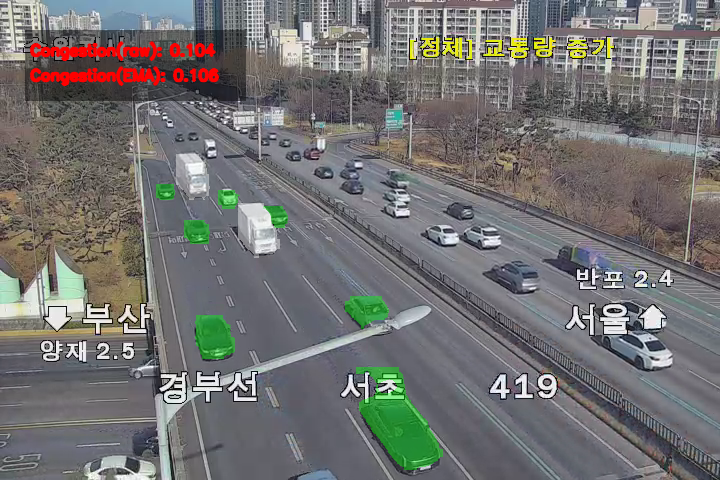

processed=50 | raw=0.061 | ema=0.072 | ROI car=8 bus=2 truck=0 | eff_fps=9.91
processed=100 | raw=0.089 | ema=0.087 | ROI car=8 bus=2 truck=1 | eff_fps=11.20
processed=150 | raw=0.063 | ema=0.075 | ROI car=7 bus=1 truck=0 | eff_fps=12.03
processed=200 | raw=0.046 | ema=0.118 | ROI car=6 bus=0 truck=0 | eff_fps=12.51
processed=250 | raw=0.040 | ema=0.054 | ROI car=4 bus=0 truck=0 | eff_fps=13.15
processed=300 | raw=0.065 | ema=0.071 | ROI car=5 bus=1 truck=0 | eff_fps=13.43
processed=350 | raw=0.040 | ema=0.062 | ROI car=6 bus=1 truck=0 | eff_fps=13.61
processed=400 | raw=0.093 | ema=0.079 | ROI car=8 bus=1 truck=0 | eff_fps=13.67
processed=450 | raw=0.054 | ema=0.058 | ROI car=7 bus=0 truck=0 | eff_fps=13.62
processed=500 | raw=0.041 | ema=0.042 | ROI car=7 bus=0 truck=0 | eff_fps=13.78
processed=550 | raw=0.104 | ema=0.097 | ROI car=9 bus=1 truck=0 | eff_fps=13.75
processed=600 | raw=0.104 | ema=0.104 | ROI car=9 bus=1 truck=0 | eff_fps=13.79
processed=650 | raw=0.053 | ema=0.061 | RO

KeyboardInterrupt: 

In [ ]:
# =========================
# REAL-TIME PIPELINE (M3U8 -> YOLOv8-seg -> Live Display)
# - input : live stream url
# - output: real-time overlay display (no saving)
# - add   : ROI-only counts + class-wise colored masks
#           car=GREEN, bus=YELLOW, truck=WHITE
# =========================

import os, sys, time, json, subprocess, shlex
import cv2
import numpy as np
import torch
from ultralytics import YOLO

# =========================
# Step 1) USER SETTINGS (EDIT ONLY HERE)
# =========================
M3U8_URL = r"""http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxYtW+bE6fzXLD6by/nC2T11tITK/D54U+SNoVmLYFAJKY="""

YOLO_PT_PATH  = "/content/best_v8s.pt"
ROI_MASK_PATH = "/content/mask.png"

MAX_FRAMES   = 10**9
PRINT_EVERY  = 50
EMA_ALPHA    = 0.10
ALPHA_MASK   = 0.40

USE_HEADERS  = False
FF_HEADERS   = "User-Agent: Mozilla/5.0\r\nReferer: https://cctvsec.ktict.co.kr/\r\n"

DISPLAY_MODE = "colab"
COLAB_SHOW_EVERY_N_FRAMES = 5

FONT = cv2.FONT_HERSHEY_SIMPLEX
FS   = 0.50
TH   = 2

CONF  = 0.25
IOU   = 0.60
IMGSZ = 1024

# ✅ car/bus가 바뀐 것 같다고 했으니 swap 반영
# (필요하면 여기만 다시 바꾸면 됨)
CLASS_ID = {
    "car": 0,
    "bus": 1,
    "truck": 2,
}

# ROI 안에 "들어왔다" 판단하는 최소 픽셀 수 (너무 작으면 노이즈로 count 튐)
MIN_ROI_PIXELS_FOR_COUNT = 80

# 색(BGR): car=초록, truck=흰색, bus=노랑
COLOR_BGR = {
    "car":   (0, 255, 0),
    "truck": (255, 255, 255),
    "bus":   (0, 255, 255),
}

# =========================
# Step 2) DEVICE
# =========================
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
USE_HALF = torch.cuda.is_available()
print("DEVICE:", DEVICE, "| half:", USE_HALF)

# =========================
# Step 3) ROI LOAD
# =========================
roi_mask_src = cv2.imread(ROI_MASK_PATH, cv2.IMREAD_GRAYSCALE)
if roi_mask_src is None:
    raise RuntimeError(f"ROI_MASK_PATH not found: {ROI_MASK_PATH}")

# =========================
# Step 4) MODEL LOAD
# =========================
model = YOLO(YOLO_PT_PATH)
print("✅ YOLO loaded:", YOLO_PT_PATH)
try:
    print("📌 model.names:", model.names)
except Exception:
    pass

# =========================
# Step 5) Helpers
# =========================
def ema_update(prev, curr, alpha):
    if prev is None:
        return curr
    return alpha * curr + (1 - alpha) * prev

def draw_label_box(img, x, y, w, h, alpha=0.45):
    o = img.copy()
    cv2.rectangle(o, (x, y), (x+w, y+h), (0,0,0), -1)
    cv2.addWeighted(o, alpha, img, 1-alpha, 0, img)

def overlay_color_roi(img_bgr, mask_bool, roi_bool, color_bgr, alpha):
    m = (mask_bool & roi_bool)
    if m.any():
        colored = np.zeros_like(img_bgr, dtype=np.uint8)
        colored[:] = color_bgr
        img_bgr[m] = (img_bgr[m] * (1 - alpha) + colored[m] * alpha).astype(np.uint8)
    return img_bgr

# =========================
# Step 6) STREAM PROBE (W,H,FPS)
# =========================
def probe_stream(url):
    cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=width,height,r_frame_rate,avg_frame_rate",
        "-of", "json", url
    ]
    out = subprocess.check_output(cmd).decode("utf-8")
    j = json.loads(out)
    s = j["streams"][0]
    W = int(s.get("width", 0))
    H = int(s.get("height", 0))

    def parse_rate(x):
        if not x or x == "0/0":
            return 0.0
        a,b = x.split("/")
        a = float(a); b = float(b)
        return a/b if b != 0 else 0.0

    fps = parse_rate(s.get("avg_frame_rate", "")) or parse_rate(s.get("r_frame_rate", "")) or 20.0
    return W, H, float(fps)

W, H, fps = probe_stream(M3U8_URL)
if W <= 0 or H <= 0:
    raise RuntimeError("ffprobe failed to read stream metadata (auth/header needed or stream inaccessible).")
print(f"🎥 Stream: size=({W},{H}), fps~{fps:.2f}")

roi_mask = cv2.resize(roi_mask_src, (W, H), interpolation=cv2.INTER_NEAREST)
roi = (roi_mask > 127)
ROI_PIXELS = int(roi.sum())
if ROI_PIXELS == 0:
    raise RuntimeError("ROI mask is empty (no white area).")

# =========================
# Step 7) START FFMPEG PIPE
# =========================
ff_cmd = ["ffmpeg", "-hide_banner", "-loglevel", "error"]
if USE_HEADERS:
    ff_cmd += ["-headers", FF_HEADERS]
ff_cmd += [
    "-i", M3U8_URL,
    "-an",
    "-vf", f"scale={W}:{H}",
    "-pix_fmt", "bgr24",
    "-f", "rawvideo",
    "pipe:1"
]
print("🧪 ffmpeg cmd:", " ".join(shlex.quote(x) for x in ff_cmd))
proc = subprocess.Popen(ff_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, bufsize=10**8)

# =========================
# Step 8) DISPLAY HELPERS
# =========================
IS_COLAB = "google.colab" in sys.modules
if DISPLAY_MODE == "colab" and not IS_COLAB:
    DISPLAY_MODE = "imshow"

if DISPLAY_MODE == "colab":
    from IPython.display import display
    import PIL.Image
    _display_handle = None

    def show_frame_colab(bgr):
        global _display_handle
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        img = PIL.Image.fromarray(rgb)
        if _display_handle is None:
            _display_handle = display(img, display_id=True)
        else:
            _display_handle.update(img)

def show_frame_imshow(bgr):
    cv2.imshow("overlay_live", bgr)
    if cv2.waitKey(1) & 0xFF == 27:
        return False
    return True

# =========================
# Step 9) MAIN LOOP
# =========================
frame_bytes = W * H * 3
ema_occ = None
frame_idx = 0
t_start = time.time()

print("✅ Start real-time inference. (Stop: interrupt/ESC)")

try:
    while frame_idx < MAX_FRAMES:
        raw = proc.stdout.read(frame_bytes)
        if raw is None or len(raw) < frame_bytes:
            err = proc.stderr.read().decode("utf-8", errors="ignore")
            raise RuntimeError("Stream ended / ffmpeg stopped.\n" + err[:2000])

        frame_bgr = np.frombuffer(raw, np.uint8).reshape((H, W, 3))

        res = model.predict(
            source=frame_bgr,
            conf=CONF,
            iou=IOU,
            imgsz=IMGSZ,
            device=0 if torch.cuda.is_available() else None,
            half=USE_HALF,
            verbose=False
        )[0]

        car_mask   = np.zeros((H, W), dtype=bool)
        bus_mask   = np.zeros((H, W), dtype=bool)
        truck_mask = np.zeros((H, W), dtype=bool)

        car_n_roi = 0
        bus_n_roi = 0
        truck_n_roi = 0

        if (res.masks is not None) and (res.boxes is not None) and (res.boxes.cls is not None):
            masks = res.masks.data.detach().cpu().numpy()  # [n,h,w] float
            cls   = res.boxes.cls.detach().cpu().numpy().astype(int)

            mh, mw = masks.shape[-2], masks.shape[-1]
            if (mh, mw) != (H, W):
                masks = np.stack(
                    [cv2.resize(m, (W, H), interpolation=cv2.INTER_LINEAR) for m in masks],
                    axis=0
                )

            for i in range(len(cls)):
                mi = (masks[i] > 0.5)

                # ✅ ROI-only count: 이 객체 마스크가 ROI와 겹치는 픽셀이 충분할 때만 카운트
                inter = int((mi & roi).sum())
                in_roi = (inter >= MIN_ROI_PIXELS_FOR_COUNT)

                if cls[i] == CLASS_ID["car"]:
                    car_mask |= mi
                    if in_roi:
                        car_n_roi += 1
                elif cls[i] == CLASS_ID["bus"]:
                    bus_mask |= mi
                    if in_roi:
                        bus_n_roi += 1
                elif cls[i] == CLASS_ID["truck"]:
                    truck_mask |= mi
                    if in_roi:
                        truck_n_roi += 1

        vehicle_union = car_mask | bus_mask | truck_mask
        vehicle_roi = vehicle_union & roi

        occ_raw = float(vehicle_roi.sum() / (ROI_PIXELS + 1e-8))
        ema_occ = ema_update(ema_occ, occ_raw, alpha=EMA_ALPHA)
        occ_ema = float(ema_occ)

        overlay = frame_bgr.copy()
        overlay = overlay_color_roi(overlay, car_mask,   roi, COLOR_BGR["car"],   ALPHA_MASK)
        overlay = overlay_color_roi(overlay, truck_mask, roi, COLOR_BGR["truck"], ALPHA_MASK)
        overlay = overlay_color_roi(overlay, bus_mask,   roi, COLOR_BGR["bus"],   ALPHA_MASK)

        draw_label_box(overlay, 25, 30, 220, 70, alpha=0.45)
        cv2.putText(overlay, f"Congestion(raw): {occ_raw:.3f}", (30, 55),
                    FONT, FS, (0,0,255), TH, cv2.LINE_AA)
        cv2.putText(overlay, f"Congestion(EMA): {occ_ema:.3f}", (30, 80),
                    FONT, FS, (0,0,255), TH, cv2.LINE_AA)

        if DISPLAY_MODE == "colab":
            if frame_idx % COLAB_SHOW_EVERY_N_FRAMES == 0:
                show_frame_colab(overlay)
        else:
            ok = show_frame_imshow(overlay)
            if not ok:
                break

        frame_idx += 1

        if frame_idx % PRINT_EVERY == 0:
            elapsed = time.time() - t_start
            fps_eff = frame_idx / max(elapsed, 1e-6)
            print(f"processed={frame_idx} | raw={occ_raw:.3f} | ema={occ_ema:.3f} | ROI car={car_n_roi} bus={bus_n_roi} truck={truck_n_roi} | eff_fps={fps_eff:.2f}")

finally:
    try:
        if DISPLAY_MODE == "imshow":
            cv2.destroyAllWindows()
    except:
        pass
    try:
        if proc and proc.poll() is None:
            proc.terminate()
    except:
        pass

print("✅ Finished.")


DEVICE: cuda:0 | half: True
✅ YOLO loaded: /content/best_v8m.pt
📌 model.names: {0: 'car', 1: 'bus', 2: 'truck'}
🎥 Stream: size=(720,480), fps~30.00
🧪 ffmpeg cmd: ffmpeg -hide_banner -loglevel error -i http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxY91u+axWIxrZkScEK4DOvZtITK/D54U+SNoVmLYFAJKY= -an -vf scale=720:480 -pix_fmt bgr24 -f rawvideo pipe:1
✅ Start real-time inference. (Stop: interrupt/ESC)


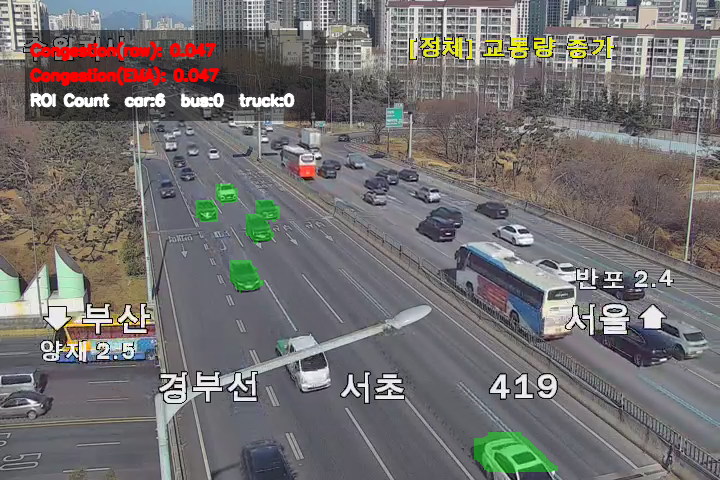

processed=50 | raw=0.078 | ema=0.086 | ROI car=5 bus=1 truck=0 | eff_fps=9.23
processed=100 | raw=0.156 | ema=0.127 | ROI car=6 bus=1 truck=1 | eff_fps=10.74
processed=150 | raw=0.053 | ema=0.057 | ROI car=5 bus=1 truck=1 | eff_fps=11.43
processed=200 | raw=0.113 | ema=0.110 | ROI car=7 bus=2 truck=2 | eff_fps=11.63
processed=250 | raw=0.133 | ema=0.116 | ROI car=8 bus=2 truck=2 | eff_fps=11.88
processed=300 | raw=0.106 | ema=0.094 | ROI car=6 bus=1 truck=2 | eff_fps=11.98
processed=350 | raw=0.095 | ema=0.095 | ROI car=3 bus=0 truck=2 | eff_fps=12.21
processed=400 | raw=0.114 | ema=0.104 | ROI car=3 bus=1 truck=1 | eff_fps=12.37
processed=450 | raw=0.172 | ema=0.148 | ROI car=3 bus=0 truck=2 | eff_fps=12.55
processed=500 | raw=0.172 | ema=0.171 | ROI car=3 bus=0 truck=2 | eff_fps=12.81
processed=550 | raw=0.073 | ema=0.106 | ROI car=7 bus=0 truck=1 | eff_fps=13.02
processed=600 | raw=0.049 | ema=0.060 | ROI car=6 bus=0 truck=0 | eff_fps=13.20
processed=650 | raw=0.099 | ema=0.097 | RO

KeyboardInterrupt: 

In [ ]:
# =========================
# REAL-TIME PIPELINE (M3U8 -> YOLOv8-seg -> Live Display)
# - input : live stream url
# - output: real-time overlay display (no saving)
# - add   : ROI-only counts + class-wise colored masks
#           car=GREEN, bus=YELLOW, truck=WHITE
# =========================

import os, sys, time, json, subprocess, shlex
import cv2
import numpy as np
import torch
from ultralytics import YOLO

# =========================
# Step 1) USER SETTINGS (EDIT ONLY HERE)
# =========================
M3U8_URL = r"""http://cctvsec.ktict.co.kr/99/jTw8fQajB9Orpw8F4vBF6Oc4LnrkvSIsOViddmasj5pd5T4fSSNYnFhMvgpSXlxY91u+axWIxrZkScEK4DOvZtITK/D54U+SNoVmLYFAJKY="""

YOLO_PT_PATH  = "/content/best_v8m.pt"
ROI_MASK_PATH = "/content/mask.png"

MAX_FRAMES   = 10**9
PRINT_EVERY  = 50
EMA_ALPHA    = 0.10
ALPHA_MASK   = 0.40

USE_HEADERS  = False
FF_HEADERS   = "User-Agent: Mozilla/5.0\r\nReferer: https://cctvsec.ktict.co.kr/\r\n"

DISPLAY_MODE = "colab"
COLAB_SHOW_EVERY_N_FRAMES = 5

FONT = cv2.FONT_HERSHEY_SIMPLEX
FS   = 0.50
TH   = 2

CONF  = 0.25
IOU   = 0.60
IMGSZ = 1024

# ✅ car/bus가 바뀐 것 같다고 했으니 swap 반영
# (필요하면 여기만 다시 바꾸면 됨)
CLASS_ID = {
    "car": 0,
    "bus": 1,
    "truck": 2,
}

# ROI 안에 "들어왔다" 판단하는 최소 픽셀 수 (너무 작으면 노이즈로 count 튐)
MIN_ROI_PIXELS_FOR_COUNT = 80

# 색(BGR): car=초록, truck=흰색, bus=노랑
COLOR_BGR = {
    "car":   (0, 255, 0),
    "truck": (255, 255, 255),
    "bus":   (0, 255, 255),
}

# =========================
# Step 2) DEVICE
# =========================
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
USE_HALF = torch.cuda.is_available()
print("DEVICE:", DEVICE, "| half:", USE_HALF)

# =========================
# Step 3) ROI LOAD
# =========================
roi_mask_src = cv2.imread(ROI_MASK_PATH, cv2.IMREAD_GRAYSCALE)
if roi_mask_src is None:
    raise RuntimeError(f"ROI_MASK_PATH not found: {ROI_MASK_PATH}")

# =========================
# Step 4) MODEL LOAD
# =========================
model = YOLO(YOLO_PT_PATH)
print("✅ YOLO loaded:", YOLO_PT_PATH)
try:
    print("📌 model.names:", model.names)
except Exception:
    pass

# =========================
# Step 5) Helpers
# =========================
def ema_update(prev, curr, alpha):
    if prev is None:
        return curr
    return alpha * curr + (1 - alpha) * prev

def draw_label_box(img, x, y, w, h, alpha=0.45):
    o = img.copy()
    cv2.rectangle(o, (x, y), (x+w, y+h), (0,0,0), -1)
    cv2.addWeighted(o, alpha, img, 1-alpha, 0, img)

def overlay_color_roi(img_bgr, mask_bool, roi_bool, color_bgr, alpha):
    m = (mask_bool & roi_bool)
    if m.any():
        colored = np.zeros_like(img_bgr, dtype=np.uint8)
        colored[:] = color_bgr
        img_bgr[m] = (img_bgr[m] * (1 - alpha) + colored[m] * alpha).astype(np.uint8)
    return img_bgr

# =========================
# Step 6) STREAM PROBE (W,H,FPS)
# =========================
def probe_stream(url):
    cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=width,height,r_frame_rate,avg_frame_rate",
        "-of", "json", url
    ]
    out = subprocess.check_output(cmd).decode("utf-8")
    j = json.loads(out)
    s = j["streams"][0]
    W = int(s.get("width", 0))
    H = int(s.get("height", 0))

    def parse_rate(x):
        if not x or x == "0/0":
            return 0.0
        a,b = x.split("/")
        a = float(a); b = float(b)
        return a/b if b != 0 else 0.0

    fps = parse_rate(s.get("avg_frame_rate", "")) or parse_rate(s.get("r_frame_rate", "")) or 20.0
    return W, H, float(fps)

W, H, fps = probe_stream(M3U8_URL)
if W <= 0 or H <= 0:
    raise RuntimeError("ffprobe failed to read stream metadata (auth/header needed or stream inaccessible).")
print(f"🎥 Stream: size=({W},{H}), fps~{fps:.2f}")

roi_mask = cv2.resize(roi_mask_src, (W, H), interpolation=cv2.INTER_NEAREST)
roi = (roi_mask > 127)
ROI_PIXELS = int(roi.sum())
if ROI_PIXELS == 0:
    raise RuntimeError("ROI mask is empty (no white area).")

# =========================
# Step 7) START FFMPEG PIPE
# =========================
ff_cmd = ["ffmpeg", "-hide_banner", "-loglevel", "error"]
if USE_HEADERS:
    ff_cmd += ["-headers", FF_HEADERS]
ff_cmd += [
    "-i", M3U8_URL,
    "-an",
    "-vf", f"scale={W}:{H}",
    "-pix_fmt", "bgr24",
    "-f", "rawvideo",
    "pipe:1"
]
print("🧪 ffmpeg cmd:", " ".join(shlex.quote(x) for x in ff_cmd))
proc = subprocess.Popen(ff_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, bufsize=10**8)

# =========================
# Step 8) DISPLAY HELPERS
# =========================
IS_COLAB = "google.colab" in sys.modules
if DISPLAY_MODE == "colab" and not IS_COLAB:
    DISPLAY_MODE = "imshow"

if DISPLAY_MODE == "colab":
    from IPython.display import display
    import PIL.Image
    _display_handle = None

    def show_frame_colab(bgr):
        global _display_handle
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        img = PIL.Image.fromarray(rgb)
        if _display_handle is None:
            _display_handle = display(img, display_id=True)
        else:
            _display_handle.update(img)

def show_frame_imshow(bgr):
    cv2.imshow("overlay_live", bgr)
    if cv2.waitKey(1) & 0xFF == 27:
        return False
    return True

# =========================
# Step 9) MAIN LOOP
# =========================
frame_bytes = W * H * 3
ema_occ = None
frame_idx = 0
t_start = time.time()

print("✅ Start real-time inference. (Stop: interrupt/ESC)")

try:
    while frame_idx < MAX_FRAMES:
        raw = proc.stdout.read(frame_bytes)
        if raw is None or len(raw) < frame_bytes:
            err = proc.stderr.read().decode("utf-8", errors="ignore")
            raise RuntimeError("Stream ended / ffmpeg stopped.\n" + err[:2000])

        frame_bgr = np.frombuffer(raw, np.uint8).reshape((H, W, 3))

        res = model.predict(
            source=frame_bgr,
            conf=CONF,
            iou=IOU,
            imgsz=IMGSZ,
            device=0 if torch.cuda.is_available() else None,
            half=USE_HALF,
            verbose=False
        )[0]

        car_mask   = np.zeros((H, W), dtype=bool)
        bus_mask   = np.zeros((H, W), dtype=bool)
        truck_mask = np.zeros((H, W), dtype=bool)

        car_n_roi = 0
        bus_n_roi = 0
        truck_n_roi = 0

        if (res.masks is not None) and (res.boxes is not None) and (res.boxes.cls is not None):
            masks = res.masks.data.detach().cpu().numpy()  # [n,h,w] float
            cls   = res.boxes.cls.detach().cpu().numpy().astype(int)

            mh, mw = masks.shape[-2], masks.shape[-1]
            if (mh, mw) != (H, W):
                masks = np.stack(
                    [cv2.resize(m, (W, H), interpolation=cv2.INTER_LINEAR) for m in masks],
                    axis=0
                )

            for i in range(len(cls)):
                mi = (masks[i] > 0.5)

                # ✅ ROI-only count: 이 객체 마스크가 ROI와 겹치는 픽셀이 충분할 때만 카운트
                inter = int((mi & roi).sum())
                in_roi = (inter >= MIN_ROI_PIXELS_FOR_COUNT)

                if cls[i] == CLASS_ID["car"]:
                    car_mask |= mi
                    if in_roi:
                        car_n_roi += 1
                elif cls[i] == CLASS_ID["bus"]:
                    bus_mask |= mi
                    if in_roi:
                        bus_n_roi += 1
                elif cls[i] == CLASS_ID["truck"]:
                    truck_mask |= mi
                    if in_roi:
                        truck_n_roi += 1

        vehicle_union = car_mask | bus_mask | truck_mask
        vehicle_roi = vehicle_union & roi

        occ_raw = float(vehicle_roi.sum() / (ROI_PIXELS + 1e-8))
        ema_occ = ema_update(ema_occ, occ_raw, alpha=EMA_ALPHA)
        occ_ema = float(ema_occ)

        overlay = frame_bgr.copy()
        overlay = overlay_color_roi(overlay, car_mask,   roi, COLOR_BGR["car"],   ALPHA_MASK)
        overlay = overlay_color_roi(overlay, truck_mask, roi, COLOR_BGR["truck"], ALPHA_MASK)
        overlay = overlay_color_roi(overlay, bus_mask,   roi, COLOR_BGR["bus"],   ALPHA_MASK)

        draw_label_box(overlay, 25, 30, 300, 90, alpha=0.45)
        cv2.putText(overlay, f"Congestion(raw): {occ_raw:.3f}", (30, 55),
                    FONT, FS, (0,0,255), TH, cv2.LINE_AA)
        cv2.putText(overlay, f"Congestion(EMA): {occ_ema:.3f}", (30, 80),
                    FONT, FS, (0,0,255), TH, cv2.LINE_AA)
        cv2.putText(overlay, f"ROI Count  car:{car_n_roi}  bus:{bus_n_roi}  truck:{truck_n_roi}", (30, 105),
                    FONT, FS, (255,255,255), TH, cv2.LINE_AA)

        if DISPLAY_MODE == "colab":
            if frame_idx % COLAB_SHOW_EVERY_N_FRAMES == 0:
                show_frame_colab(overlay)
        else:
            ok = show_frame_imshow(overlay)
            if not ok:
                break

        frame_idx += 1

        if frame_idx % PRINT_EVERY == 0:
            elapsed = time.time() - t_start
            fps_eff = frame_idx / max(elapsed, 1e-6)
            print(f"processed={frame_idx} | raw={occ_raw:.3f} | ema={occ_ema:.3f} | ROI car={car_n_roi} bus={bus_n_roi} truck={truck_n_roi} | eff_fps={fps_eff:.2f}")

finally:
    try:
        if DISPLAY_MODE == "imshow":
            cv2.destroyAllWindows()
    except:
        pass
    try:
        if proc and proc.poll() is None:
            proc.terminate()
    except:
        pass

print("✅ Finished.")